<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_Predicci%C3%B3n_de_cancelaci%C3%B3n_de_reserva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Predicción de cancelación de reserva

**Nombre**: Pablo Saavedra <br />
**Curso**: Modelos avanzados y Redes Neuronales (G105)


---

### Importación de librerías

In [98]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs, make_circles
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

import keras_tuner as kt
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import optimizers

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format



In [93]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.7 MB/s eta 0:00:00


### Funciones útiles

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto', _title=""):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col} {_title}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def eval_model_short(name, model):
  y_pred = model.predict(X_test)
  # Para AUC necesitamos probas de clase 1
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

  print(f"{name:>18} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [5]:
from typing import Optional, Iterable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def eval_model_preds(
    X_train, y_train,
    X_test,  y_test,
    y_pred_train,
    y_pred_test,
    class_names: Optional[Iterable[str]] = None,
    *,
    normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
    average: str = "weighted",           # "macro" | "weighted" | "micro"
    plot: bool = True,
    title_prefix: str = "",
    # scores para binario (p.ej. proba[:,1] o decision_function)
    pos_scores_train: Optional[np.ndarray] = None,
    pos_scores_test: Optional[np.ndarray] = None,
    binary_threshold: Optional[float] = None,  # si no None y hay scores, recalcula y_pred
    zero_division: int = 0,
    label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
    """
    Evalúa un clasificador en train/test con métricas y (opcional) gráficos,
    recibiendo predicciones ya calculadas (sin pasar el modelo).

    - y_pred_train/y_pred_test: predicción final (clase).
    - pos_scores_* (opcional): scores de clase positiva para AUC/ROC/PR (binario).
    """

    # ---------------------------
    # 0) Preparación / tipos
    # ---------------------------
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    y_pred_train = np.asarray(y_pred_train)
    y_pred_test  = np.asarray(y_pred_test)

    target_kind = type_of_target(y_test)
    is_binary = target_kind == "binary"

    # Si viene un mapeo explícito, aplícalo a y_* reales
    if label_map is not None:
        y_train = np.vectorize(label_map.get)(y_train)
        y_test  = np.vectorize(label_map.get)(y_test)

    # Si hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
    def _needs_alignment(y_true, y_pred):
        return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

    if _needs_alignment(y_test, y_pred_test):
        if not is_binary:
            raise TypeError(
                "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
                "Pasa 'label_map' o codifica etiquetas (LabelEncoder)."
            )
        if class_names is not None and len(list(class_names)) == 2:
            auto_map = {list(class_names)[0]: 0, list(class_names)[1]: 1}
            y_train = np.vectorize(auto_map.get)(y_train)
            y_test  = np.vectorize(auto_map.get)(y_test)
        else:
            uniq = list(np.unique(y_train))
            if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
                auto_map = {uniq[0]: 0, uniq[1]: 1}
                y_train = np.vectorize(auto_map.get)(y_train)
                y_test  = np.vectorize(auto_map.get)(y_test)
            else:
                raise TypeError(
                    "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                    "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
                )

    # ---------------------------
    # 1) Umbral binario (si aplica) usando scores
    # ---------------------------
    if is_binary and (pos_scores_train is not None or pos_scores_test is not None) and (binary_threshold is not None):
        thr = float(binary_threshold)
        if pos_scores_train is not None:
            y_pred_train = (np.asarray(pos_scores_train) >= thr).astype(int)
        if pos_scores_test is not None:
            y_pred_test  = (np.asarray(pos_scores_test)  >= thr).astype(int)

    # ---------------------------
    # 2) Métricas numéricas
    # ---------------------------
    metrics: Dict[str, Any] = {}

    def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )
        mcc = matthews_corrcoef(y_true, y_pred)
        return {
            f"{split}_accuracy": acc,
            f"{split}_balanced_accuracy": bacc,
            f"{split}_precision_{average}": p,
            f"{split}_recall_{average}": r,
            f"{split}_f1_{average}": f1,
            f"{split}_mcc": mcc
        }

    metrics.update(block_metrics(y_train, y_pred_train, "train"))
    metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

    # AUCs si tenemos scores (binario)
    if is_binary and (pos_scores_test is not None):
        try:
            if pos_scores_train is not None:
                metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
                metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
            metrics["test_roc_auc"] = roc_auc_score(y_test, pos_scores_test)
            metrics["test_pr_auc"]  = average_precision_score(y_test, pos_scores_test)
        except Exception:
            pass

    # ---------------------------
    # 3) Reportes por clase
    # ---------------------------
    prefix = (title_prefix + " ") if title_prefix else ""
    print(prefix + "Reporte de clasificación (train):")
    print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
    print(prefix + "Reporte de clasificación (test):")
    print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

    # ---------------------------
    # 4) Gráficos
    # ---------------------------
    if plot:
        has_scores = is_binary and (pos_scores_test is not None)
        fig, axes = (plt.subplots(2, 2, figsize=(10, 8)) if has_scores
                     else plt.subplots(1, 2, figsize=(10, 4)))
        axes = np.array(axes).flatten()

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_train, y_pred=y_pred_train,
            display_labels=class_names, normalize=normalize_cm, ax=axes[0]
        )
        axes[0].set_title(f"{title_prefix} Confusión (train)")

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_pred_test,
            display_labels=class_names, normalize=normalize_cm, ax=axes[1]
        )
        axes[1].set_title(f"{title_prefix} Confusión (test)")

        if has_scores:
            RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
            axes[2].set_title(f"{title_prefix} ROC (test)")

            PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
            axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

        plt.tight_layout()
        plt.show()

    return metrics


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', fontsize=10):
  '''
    plot_type: acepta valores in ['hist', 'boxplot']
  '''

  nrows = df.shape[1]//ncols
  if nrows*ncols < df.shape[1]:
    nrows += 1

  fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

  i = 0
  for idx, (colname, serie)  in enumerate(df.items()):
    j = (idx % ncols)

    ax[i,j].set_title(colname, fontsize=fontsize)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)

    if serie.unique().shape[0] <= max_discrete:

        serie = serie.value_counts().sort_values(ascending=True)

        ax_aux = ax[i,j].barh(
            y=np.array(serie.index).astype('str'),
            width=serie.values,
        )
    else:
        if plot_type == 'hist':
            ax[i,j].hist(x=serie, color='xkcd:tomato', density=True, alpha=0.7)
            ax[i,j].axvline(x=np.mean(serie), color='xkcd:black', ls='--', lw=0.8)
        elif plot_type == 'boxplot':
            ax[i,j].boxplot(serie)
            ax[i,j].set_xticklabels([''])

    if (j == ncols-1): i += 1

  plt.tight_layout()
  plt.show()


def plot_roc (X_test, y_test, lst_model, lst_model_name):

    plt.figure(figsize=(8, 6))
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    for idx, model in enumerate(lst_model):

        yhat_test_proba = model.predict_proba(X_test)[:, 1]

        # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
        fpr, tpr, umbrales = roc_curve(y_test, yhat_test_proba)

        # Calcular el área bajo la curva ROC (AUC)
        auc = np.round(roc_auc_score(y_test, yhat_test_proba), 4)

        # Plot de la curva ROC
        plt.plot(fpr, tpr, lw=1.5, label=f'{lst_model_name[idx]} AUC = {auc})')

    plt.legend(loc='lower right')
    plt.show()

## 1. Carga de datos

Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow, además de las librerías para realizar regularización y búsqueda de grilla.

Luego, debes descartar las columnas **index**, **arrival_date_year**, **agent**, **country**,
**company**, **reservation_status** y **reservation_status_date**. Revisa después si la base de datos presenta valores ausentes; en el caso que existan deberá eliminar estos registros siempre y cuando la cantidad sea menor al 4% del total. En caso que sea superior debes decidir si quitar la característica o imputar los datos faltantes aplicando alguna estrategía, que debes describir

---

### Carga de datos

In [3]:
# Carga de datos
df = pd.read_csv("/content/drive/MyDrive/hotel_bookings.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   index                           119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   is_canceled                     119390 non-null  int64  
 3   lead_time                       119390 non-null  int64  
 4   arrival_date_year               119390 non-null  int64  
 5   arrival_date_month              119390 non-null  object 
 6   arrival_date_week_number        119390 non-null  int64  
 7   arrival_date_day_of_month       119390 non-null  int64  
 8   stays_in_weekend_nights         119390 non-null  int64  
 9   stays_in_week_nights            119390 non-null  int64  
 10  adults                          119390 non-null  int64  
 11  children                        119386 non-null  float64
 12  babies          

In [7]:
# Descartar columnas
df = df.drop(columns=["index", "arrival_date_year", "agent", "country", "company", "reservation_status", "reservation_status_date"])

In [14]:
# Revisar si hay datos ausentes
print("Datos ausentes: ", df.isnull().sum())

Datos ausentes:  hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64


In [18]:
# Como los datos ausentes son menores al 4% se procede a eliminar los registros nulos
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119386 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119386 non-null  object 
 1   is_canceled                     119386 non-null  int64  
 2   lead_time                       119386 non-null  int64  
 3   arrival_date_month              119386 non-null  object 
 4   arrival_date_week_number        119386 non-null  int64  
 5   arrival_date_day_of_month       119386 non-null  int64  
 6   stays_in_weekend_nights         119386 non-null  int64  
 7   stays_in_week_nights            119386 non-null  int64  
 8   adults                          119386 non-null  int64  
 9   children                        119386 non-null  float64
 10  babies                          119386 non-null  int64  
 11  meal                            119386 non-null  object 
 12  market_segment       

In [19]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,July,27,1,0,0,2,0.00,...,0,C,C,3,No Deposit,0,Transient,0.00,0,0
1,Resort Hotel,0,737,July,27,1,0,0,2,0.00,...,0,C,C,4,No Deposit,0,Transient,0.00,0,0
2,Resort Hotel,0,7,July,27,1,0,1,1,0.00,...,0,A,C,0,No Deposit,0,Transient,75.00,0,0
3,Resort Hotel,0,13,July,27,1,0,1,1,0.00,...,0,A,A,0,No Deposit,0,Transient,75.00,0,0
4,Resort Hotel,0,14,July,27,1,0,2,2,0.00,...,0,A,A,0,No Deposit,0,Transient,98.00,0,1


## Análisis de los datos

Realiza un análisis descriptivo y prepara los datos. Para esto:

a. Selecciona 5 variables que consideres relevantes (que no sean la variable
adr) con respecto a cancelar una reserva.

b. Construye un histograma para la variable adr con reservas canceladas y no
canceladas, y comenta el resultado.

c. Revisa la presencia de outlier para la variable adr. En caso que presente
valores extremos indica la cantidad de outliers por arriba, y la cantidad de
outlier por abajo. Eliminar sólo los tres valores más extremos en ambos
casos, para los demás cambia sus valores por el valor promedio de la
variable.

d, Transforma las variables categóricas en variables dummies, estandariza las
variables independientes con media igual a cero y desviación estándar 1 y
realiza una división de los datos para entrenamiento y test, este último con un
33% de registros.

---

### Distribución de los datos

In [20]:
df.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,"119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00","119,386.00"
mean,0.37,104.01,27.17,15.80,0.93,2.50,1.86,0.10,0.01,0.03,0.09,0.14,0.22,2.32,101.83,0.06,0.57
std,0.48,106.86,13.61,8.78,1.00,1.91,0.58,0.40,0.10,0.18,0.84,1.50,0.65,17.60,50.53,0.25,0.79
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-6.38,0.00,0.00
25%,0.00,18.00,16.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,69.29,0.00,0.00
50%,0.00,69.00,28.00,16.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,94.59,0.00,0.00
75%,1.00,160.00,38.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.00,0.00,1.00
max,1.00,737.00,53.00,31.00,19.00,50.00,55.00,10.00,10.00,1.00,26.00,72.00,21.00,391.00,"5,400.00",8.00,5.00


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119386 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119386 non-null  object 
 1   is_canceled                     119386 non-null  int64  
 2   lead_time                       119386 non-null  int64  
 3   arrival_date_month              119386 non-null  object 
 4   arrival_date_week_number        119386 non-null  int64  
 5   arrival_date_day_of_month       119386 non-null  int64  
 6   stays_in_weekend_nights         119386 non-null  int64  
 7   stays_in_week_nights            119386 non-null  int64  
 8   adults                          119386 non-null  int64  
 9   children                        119386 non-null  float64
 10  babies                          119386 non-null  int64  
 11  meal                            119386 non-null  object 
 12  market_segment       

In [30]:
variables_cuantitativas = ["lead_time","arrival_date_month","arrival_date_week_number","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","adr","required_car_parking_spaces","total_of_special_requests"]
variables_cualitativas = ["hotel","is_canceled","meal","market_segment","distribution_channel","is_repeated_guest","reserved_room_type","assigned_room_type","deposit_type","customer_type"]

In [32]:
# Convertir variables meses en string a númericas
df["arrival_date_month"] = df["arrival_date_month"].map({
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
})

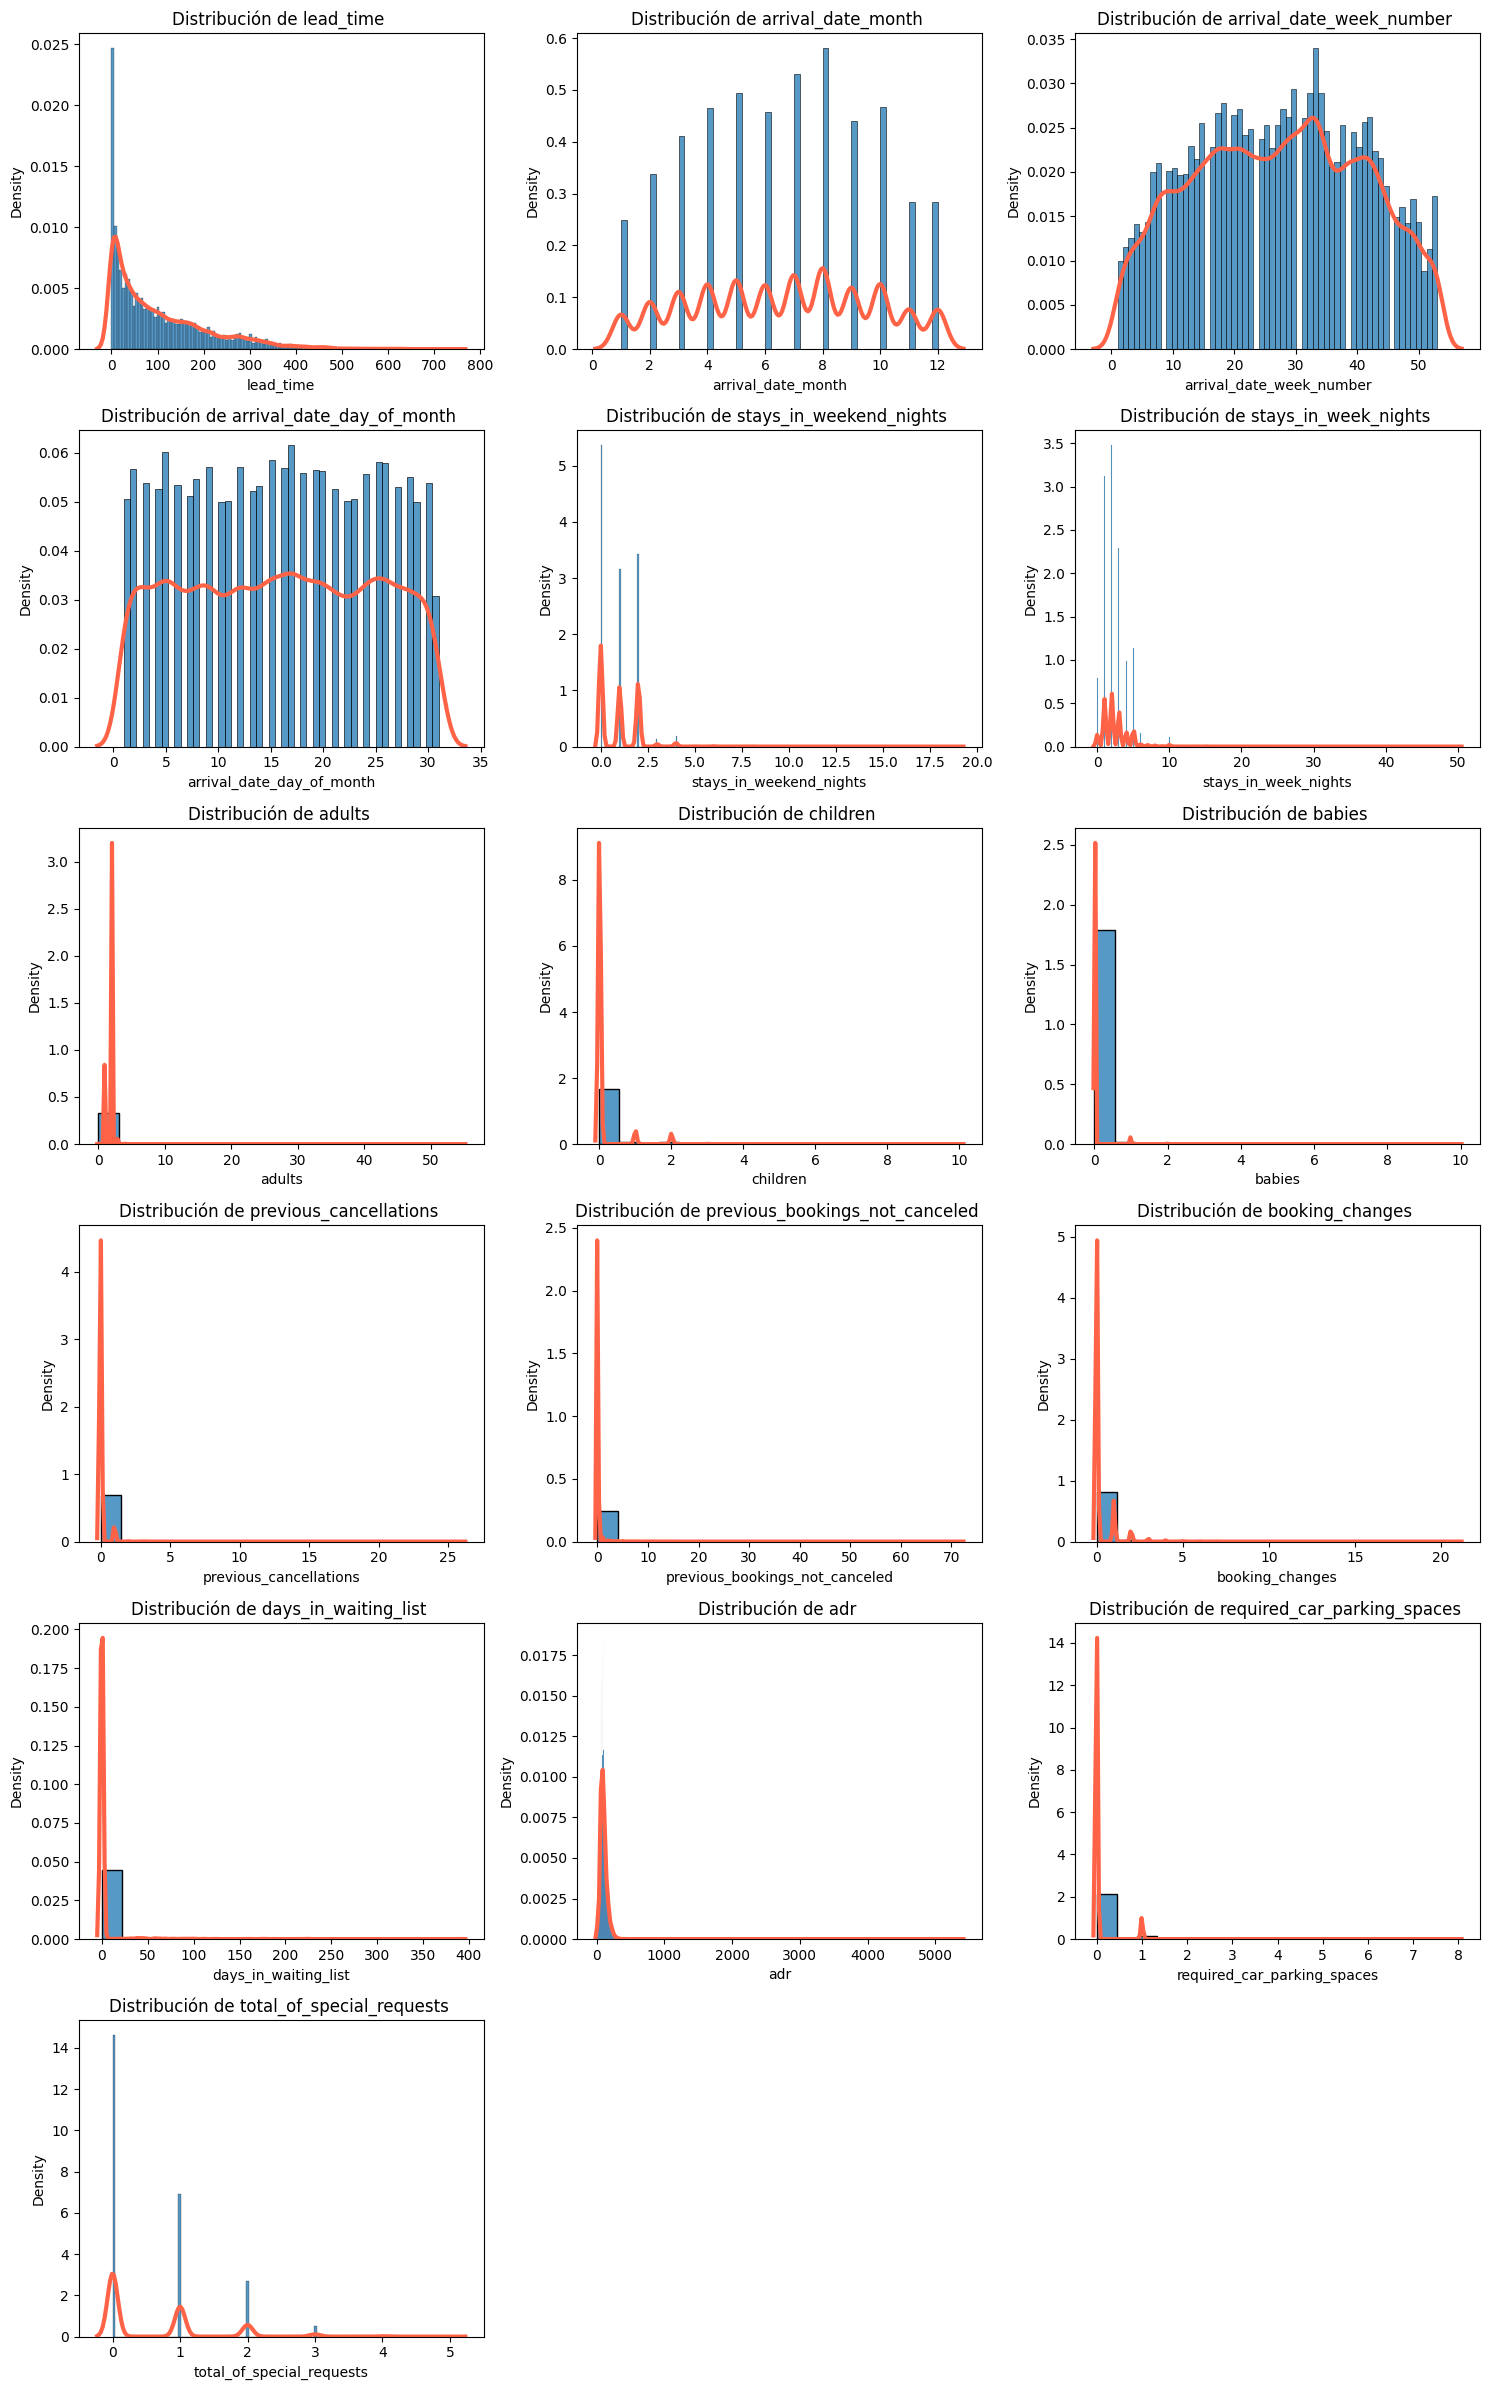

In [34]:
plot_hist(df, variables_cuantitativas)

> - **Aproximadamente normales / simétricas**: No existen variables que distribuyan de forma normal.
>
> - **Fuertemente asimétricas a la derecha (positiva)**: Casi todas tienen asimetria a la derecha.
>
> - **Distibución uniforme**: arrive_day_of_month.
>
> - **Distribución multinomial**: arrival_date_month y arrival_date_week_number.


### 2.a. Selección de Variables
Para la selección de las 5 características se utilizará un clasificador RandomForest y se obtendran el top de las características importantes

In [53]:
# Convertir las variables categoricas a números
df_aux = df.copy()
for c in df_aux.select_dtypes(include=["object", "category"]).columns:
    df_aux[c] = df_aux[c].astype("category").cat.codes

X = df_aux.drop(columns=["is_canceled"])
y = df_aux["is_canceled"]

# Entrenar un clasificador
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_

# Obtener nombres de columnas si X_train es DataFrame
if hasattr(X, "columns"):
    feature_names = np.array(X.columns)
else:
    feature_names = np.array([f"feature_{i}" for i in range(X.shape[1])])

top_idx = np.argsort(importances)[::-1][:10]

top_features = pd.DataFrame({
    "feature": feature_names[top_idx],
    "importance": importances[top_idx]
}).reset_index(drop=True)

print("\nTop 10 características más importantes (RandomForest):")
print(top_features)


Top 10 características más importantes (RandomForest):
                     feature  importance
0                  lead_time        0.16
1               deposit_type        0.15
2                        adr        0.11
3  arrival_date_day_of_month        0.07
4  total_of_special_requests        0.06
5   arrival_date_week_number        0.06
6             market_segment        0.05
7       stays_in_week_nights        0.04
8     previous_cancellations        0.04
9         arrival_date_month        0.04


> Según los resultados se selecciona las siguientes 5 variables:
> 1. lead_time (0.16)
> 2. deposit_type (0.15)
> 3. arrival_date_day_of_month (0.07)
> 4. total_of_special_requests (0.06)
> 5. arrival_date_week_number (0.06)

In [73]:
variables_seleccionadas = ["lead_time","deposit_type","arrival_date_day_of_month","total_of_special_requests","arrival_date_week_number", "adr"]

### 2.b. ADR


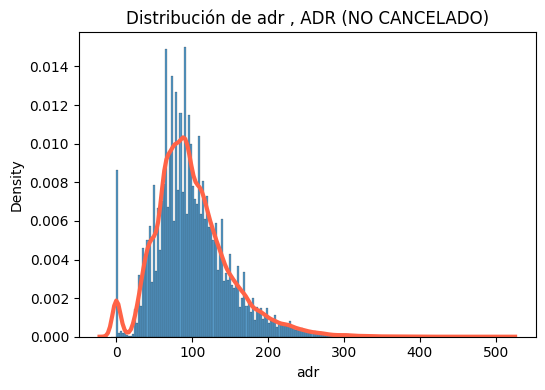

In [55]:
plot_hist(df[df["is_canceled"] == 0], ["adr"], _title=", ADR (NO CANCELADO)")

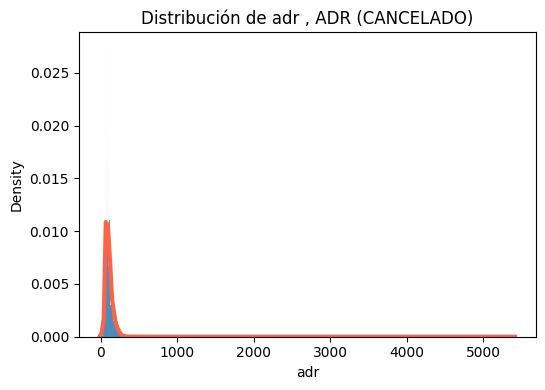

In [56]:
plot_hist(df[df["is_canceled"] == 1], ["adr"], _title=", ADR (CANCELADO)")

> Los cacelados están concentrados cerca de cero, mientras que los no cancelados están concentrados en cero y 100 aproximadamente.

### 2.c. Outliers ADR

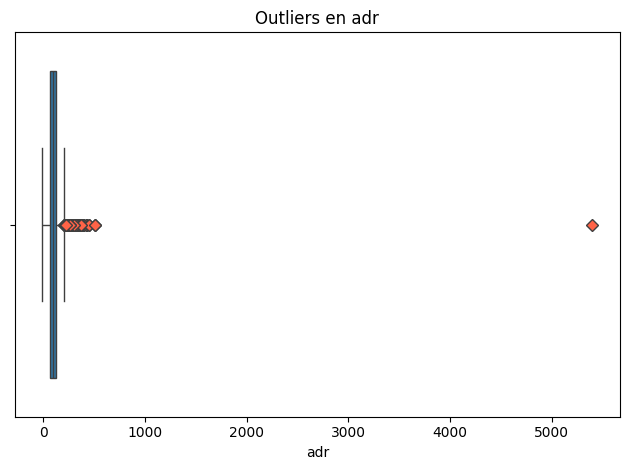

In [62]:
col = 'adr'
sns.boxplot(x=df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'})
plt.title(f"Outliers en {col}")
plt.xlabel(col)

plt.tight_layout()
plt.show()

> No tiene outliers por abajo. Pero si tiene outliers por arriba

In [63]:
# Eliminar outliers

# Eliminar los 3 más altos
df = df.drop(index=df[col].nlargest(3).index).reset_index(drop=True)

# asignar promedio
_k = 1.5
q1, q3 = df[col].quantile([.25, .75])
iqr = q3 - q1
low, high = q1 - _k * iqr, q3 + _k * iqr
mask = (df[col] > high)

# 1) sacar outliers del cálculo
df.loc[mask, col] = np.nan

# 2) calcular promedio sin outliers y reemplazar
mean_wo_outliers = df[col].mean()
df.loc[mask, col] = mean_wo_outliers


### 2.d. Preparar datos

In [105]:
# 1) Separar X e y
target = "is_canceled"
X = df.drop(columns=[target])
y = df[target]

# 2) Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns
num_cols = X.columns.difference(cat_cols)

# 3) Split: 33% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# 4) Preprocesamiento: dummies + estandarización (media igual a 0 y desviación a 1)
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)

# Ajustar SOLO con train (evita data leakage) y transformar ambos
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

# Recuperar nombres de columnas tras dummies
feature_names = preprocess.get_feature_names_out()

# Volver a DataFrame
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=X_train.index)
X_test_prep  = pd.DataFrame(X_test_prep,  columns=feature_names, index=X_test.index)

In [106]:
X_train_prep.head()

,num__adr,num__adults,num__arrival_date_day_of_month,num__arrival_date_month,num__arrival_date_week_number,num__babies,num__booking_changes,num__children,num__days_in_waiting_list,num__is_repeated_guest,...,cat__assigned_room_type_I,cat__assigned_room_type_K,cat__assigned_room_type_P,cat__deposit_type_No Deposit,cat__deposit_type_Non Refund,cat__deposit_type_Refundable,cat__customer_type_Contract,cat__customer_type_Group,cat__customer_type_Transient,cat__customer_type_Transient-Party
30216,-1.02,0.24,0.02,1.44,1.46,-0.08,-0.34,-0.26,-0.13,-0.18,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
58167,1.11,1.95,-1.00,1.12,1.02,-0.08,-0.34,-0.26,-0.13,-0.18,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
89679,0.81,0.24,0.59,-0.50,-0.45,-0.08,-0.34,-0.26,-0.13,-0.18,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
14523,-1.30,0.24,1.05,-1.47,-1.33,-0.08,-0.34,-0.26,-0.13,-0.18,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
110960,1.95,-1.46,-1.34,-0.50,-0.67,-0.08,-0.34,-0.26,-0.13,-0.18,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


## 3. Modelos

Implementa dos modelos de red neuronal multicapa, considerando las siguientes
características.

a. Cada modelo debe contar con tres capas ocultas.

b. El primer modelo debe tener funciones de activación tanh, relu y tanh en las
capas ocultas, mientras que el segundo sólo funciones tanh en sus capas
ocultas.

c. Cada modelo debe tener un mínimo de 20 neuronas para cada capa oculta.

Use un optimizador SGD, con 10 épocas de entrenamiento; cada capa deberá
tener una neurona de sesgo. Debes decidir cómo se inicializan los pesos y el
sesgo en cada capa oculta y de salida.
Muestra los resultados en un gráfico que tendrá una curva de accuracy para cada
modelo en cada época de entrenamiento. Cada modelo debe lograr un accuracy
superior al 75%. Concluye de acuerdo a los resultados.

---


In [107]:
def create_model(
    n_features,
    activations,
    n_hidden_layers,
    units,
    k_initializer=HeNormal(),
    bias_initializer='zeros',
):
  ann = Sequential()

  ann.add(keras.Input(shape=(n_features, )))

  constraint = max_norm(3)

  for idx, hl in enumerate(range(1, n_hidden_layers+1)):
      ann.add(
          layers.Dense(
              units=units,
              use_bias=True,
              activation=activations[idx],
              kernel_initializer=k_initializer[idx],
              bias_initializer=bias_initializer[idx],
              kernel_constraint=constraint
          )
      )

  ann.add(
      layers.Dense(
          units=1,
          use_bias=True,
          activation='sigmoid',
          kernel_initializer='glorot_normal',
          bias_initializer='zeros',
          kernel_constraint=constraint
      )
  )

  return ann



In [108]:
# Primer modelo
ann1 = create_model(
        n_features=X_train_prep.shape[1],
        activations=['tanh', 'relu', 'tanh'],
        n_hidden_layers=3,
        units=20,
        k_initializer=['glorot_normal', 'he_normal', 'glorot_normal'],
        bias_initializer=['glorot_uniform'] * 3
    )

ann1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,141 (8.36 KB)

 Trainable params: 2,141 (8.36 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Segundo modelo
ann2 = create_model(
        n_features=X_train_prep.shape[1],
        activations=['tanh', 'tanh', 'tanh'],
        n_hidden_layers=3,
        units=20,
        k_initializer=['glorot_normal', 'glorot_normal', 'glorot_normal'],
        bias_initializer=['glorot_uniform'] * 3
    )

ann2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,141 (8.36 KB)

 Trainable params: 2,141 (8.36 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
histories = {}
models = {}
models['modelo 1'] = ann1
models['modelo 2'] = ann2

for name, model in models.items():
    opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    histories[name] = model.fit(
        X_train_prep, y_train,
        validation_data=(X_test_prep, y_test),
        epochs=10,
        batch_size=32,
        verbose=0
    )

    test_loss, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)
    print(f"{name} -> Test accuracy: {test_acc:.3f}")

modelo 1 -> Test accuracy: 0.827
modelo 2 -> Test accuracy: 0.829


> Ambos modelos obtienen resultados muy parecidos aunque el segundo modelo presenta un mejor accuracy (0.829)

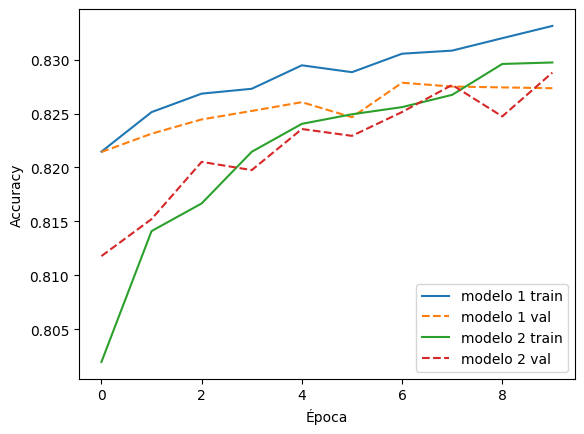

In [112]:
plt.figure()
for name, h in histories.items():
    plt.plot(h.history["accuracy"], label=f"{name} train")
    plt.plot(h.history["val_accuracy"], linestyle="--", label=f"{name} val")

plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> Ambos modelos presentan una buena evolución del entrenamiento, probablemente con más epocas se mejoraría el resultado.

## 4. Regularización

Construye una red neuronal con regularización Dropout aplicando búsqueda de grilla
para tres fold. El modelo debe conseguir un accuracy superior al 80%. La búsqueda
debe sintonizar los siguientes hiper parámetros:

a. Cantidad de capas ocultas: de 3 o 4

b. Método de optimización: Adam o SGD

c. learning_rate: 0.03 y 0.06

d. Cantidad de neuronas en las capas ocultas: 20

e. Funciones de activación en las capas ocultas: tanh

f. Rate para Dropout: 0.001

g. Inicialización de los pesos: [glorot_normal, glorot_uniform]

Debes mostrar los hiper parámetros óptimos encontrados por la búsqueda de grilla.
Calcula además las métricas asociadas a la matriz de confusión al aplicar el
modelo con los hiper parámetros óptimos al conjunto de test. Muestra la curva ROC
para el mejor modelo incluyendo el AUC.



In [113]:
def call_existing_code(
    n_hidden_layers,
    units,
    activation,
    dropout,
    dropout_rate,
    kernel_initializer,
    bias_initializer,
    optimizer,
    learning_rate,
):

    # Restricción para garantizar que la norma de cada
    # vector de pesos no exceda de tres.
    constraint = max_norm(3)

    # Arquitectura secuencial
    model = Sequential()

    # Capas ocultas
    for hl in range(n_hidden_layers):
        model.add(
            layers.Dense(
                units=units,
                use_bias=True,
                activation=activation,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_constraint=constraint,
            )
        )
        if dropout:
          model.add(layers.Dropout(rate=dropout_rate))

    model.add(
        layers.Dense(
            units=1,
            use_bias=True,
            activation="sigmoid",
            kernel_initializer="glorot_normal",
            bias_initializer=bias_initializer,
            kernel_regularizer=l1(l1=0.001),
            kernel_constraint=constraint,
        )
    )

    if optimizer == "SGD":
        opt = optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "adagrad":
        opt = optimizers.Adagrad(learning_rate=learning_rate)

    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    # When no explicit metrics, loss is used. And objective="val_loss"
    # in the keras_tuner.RandomSearch object
    # model.compile(loss="binary_crossentropy", optimizer=opt)

    return model


In [114]:
def build_model(hp):
    n_hidden_layers = hp.Choice("n_hidden_layers", [3, 4])
    # units = hp.Int("units", min_value=20, max_value=512, step=32)
    units = 20
    # activation = hp.Choice("activation", ["relu", "tanh"])
    activation = "tanh"
    dropout = hp.Boolean("dropout")
    dropout_rate = 0.001
    kernel_initializer = hp.Choice(
        "kernel_initializer", ["glorot_normal", "glorot_uniform"]
    )
    bias_initializer = hp.Choice("bias_initializer", ["zeros", "glorot_uniform"])
    optimizer = hp.Choice("optimizer", ["SGD", "adagrad"])
    learning_rate = hp.Choice("learning_rate", [0.03, 0.06])  # Added

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        n_hidden_layers,
        units,
        activation,
        dropout,
        dropout_rate,
        kernel_initializer,
        bias_initializer,
        optimizer,
        learning_rate,  # Added
    )

    return model


build_model(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    # objective="val_loss",
    max_trials=20,  # more trials, better results. I used 60
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

#print(tuner.search_space_summary())

print("\ntuner search")
tuner.search(X_train_prep, y_train, epochs=5, validation_data=(X_test_prep, y_test))

#print(tuner.results_summary())

# Get the top num models.
models = tuner.get_best_models(num_models=2)

# Get the best model.
best_model = models[0]

print(best_model.summary())

# Get the top n hyperparameters.
best_hps = tuner.get_best_hyperparameters(20)

# Build the model with the best hp.
model = build_model(best_hps[0])

print("\nfitting best model")
model.fit(X_train_prep, y_train, epochs=30)

# Optional for production-ready: Fit with the entire dataset.
# X_all = np.concatenate((X_train, X_test))
# y_all = np.concatenate((y_train, y_test))
# model.fit(X_all, y_all, epochs=20)

print("\npredicting on X_test")
yhat = model.predict(X_test_prep)

yhat_class = (yhat > 0.5).astype(int)

print("\nclassification report")
print(classification_report(y_test, yhat_class))

Trial 20 Complete [00h 00m 39s]
val_accuracy: 0.823006808757782

Best val_accuracy So Far: 0.8234890699386597
Total elapsed time: 00h 13m 02s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adagrad', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

None

fitting best model
Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7893 - loss: 0.4544
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8133 - loss: 0.4037
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8157 - loss: 0.3965
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8200 - loss: 0.3877
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8230 - loss: 0.3823
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8215 - loss: 0.3831
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8221 - loss: 0.3817
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8247 - loss: 0.3808
Epoch 9/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8237 - loss: 0.3793
Epoch 10/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8280 - loss: 0.3740
Epoch 11/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8289 - loss: 0.3727
Epoc

> El accuracy fue de 83%

AUC (TEST): 0.9016


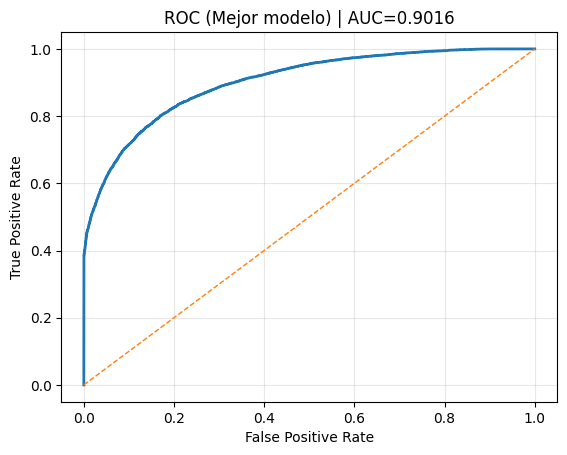

In [115]:
test_proba = model.predict(X_test_prep, verbose=0).ravel()
auc_test = roc_auc_score(y_test, test_proba)
print("AUC (TEST):", round(auc_test, 4))

fpr, tpr, _ = roc_curve(y_test, test_proba)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (Mejor modelo) | AUC={auc_test:.4f}")
plt.grid(True, alpha=0.3)
plt.show()

In [120]:
_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(_best_hps.values)

{'n_hidden_layers': 4, 'dropout': True, 'kernel_initializer': 'glorot_uniform', 'bias_initializer': 'glorot_uniform', 'optimizer': 'adagrad', 'learning_rate': 0.06}


> - **AUC (Validación) = 0.9016**: El modelo ordena detecta bien los que cancelan.
>
>  - **Configuracion**: La mejor configuración fue de:
>     - **n_hidden_layers**: 4
>     - **dropout**: True
>     - **kernel_initializer**: 'glorot_uniform'
>     - **bias_initializer**: 'glorot_uniform'
>     - **optimizer**: 'adagrad'
>     - **learning_rate**: 0.06
>
> - **Curva ROC**: En la parte inicial (FPR baja), la curva sube rápido: indica que puedes conseguir buen recall sin “pagar” demasiados falsos positivos.
> - **Resultado**: El modelo presenta alta capacidad discriminativa (AUC_test=0.9016).

## 5. Probar mejor modelo

Del conjunto original (sin los valores excluidos) escoge al azar cinco observaciones
en que “deposit_type_Non Refund” sea cero, y con esto realiza una predicción
usando el mejor modelo encontrado por la búsqueda de grilla anterior. Comenta los
resultados.

---


In [129]:
muestras = df[df["deposit_type"] == "Non Refund"].sample(n=5, random_state=42)

X = muestras.drop(columns=[target])
y = muestras[target]

X  = preprocess.transform(X)

y_proba = model.predict(X, verbose=0).ravel()

df_datos = pd.DataFrame({
    "muestra": muestras.index.to_list(),
    "y_proba": y_proba,
    "y": y
})

df_datos

,muestra,y_proba,y
64929,64929,1.00,1
82008,82008,1.00,1
44119,44119,1.00,1
71450,71450,0.99,1
6471,6471,0.99,1


> El modelo esta prediciendo correctamente en esta muestra. El modelo devuelve una probabilidad de ser la clase cancelado debido a que utiliza como función no lineal la función sigmoide.